In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [4]:
from scipy.integrate import trapz, cumtrapz
import numpy, pandas as pd, h5py
pd.options.mode.chained_assignment = None
import pylab, numpy
import seaborn as sns
sns.set_context('talk') 
sns.set_palette('colorblind')
sns.set_style('ticks')

pylab.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

pylab.rcParams['axes.linewidth'] = 1

In [5]:
with h5py.File('/home/koustav.chandra/O3/XML2hdf/gw190521.h5', 'r') as f:
    combined_fap = f['injection_bin_{}/combined_fap'.format(0)][()]

livetime_of_pipelines = [0.7343, 0.747, 0.874]
ifar_threshold = 100
fap_threshold = 1 - numpy.exp(-numpy.max(livetime_of_pipelines)/ifar_threshold)
N_rec = numpy.shape(numpy.where(combined_fap <= fap_threshold))[1]
N_tot = 313957
VT_tot = 190.984
VT_190521 = N_rec/N_tot*VT_tot

In [6]:
def poisson_with_prior(R, VT, Nobs, prior=lambda x: 1):

    if callable(prior):
        likelihood = R**Nobs * numpy.exp(-R * VT)
        norm = trapz(likelihood * prior(R), R)
        return likelihood * prior(R) / norm

def get_CI(Ps,R,CL):
    CDF = cumtrapz(Ps, R)
    i_span = numpy.where( (CDF>0.5-CL/2) & (CDF<0.5+CL/2) )[0]
    ilow, ihigh = i_span[0], i_span[-1]
    imed = numpy.where(CDF>0.5)[0][0]
    rmed = R[imed]
    rmax = R[numpy.argmax(Ps)]
    print('rmax: ',rmax)
    print(R[ilow], rmed, R[ihigh], CDF[-1])
    rplus, rminus = R[ihigh] - rmed, rmed - R[ilow]
    return rminus, rmed, rplus

def get_bounds_single(R, VT, Nobs, CL, fp, prior= lambda x: 1):
    Ps = fp(R, VT, Nobs, prior)
    CDF = cumtrapz(Ps, R)
    i_span = numpy.where( (CDF>0.5-CL/2) & (CDF<0.5+CL/2) )[0]
    ilow, ihigh = i_span[0], i_span[-1]
    imed = numpy.where(CDF>0.5)[0][0]
    rmed = R[imed]
    rmax = R[numpy.argmax(Ps)]
    print('rmax: ',rmax)
    print(R[ilow], rmed, R[ihigh], CDF[-1])
    rplus, rminus = R[ihigh] - rmed, rmed - R[ilow]
    return rminus, rmed, rplus

def get_bounds_kkl(R, vt2, vt1, CL, prior=lambda x: 1):
    Ps = kkl_with_prior(vt1, vt2, R, prior)
    CDF = cumtrapz(Ps, R)
    i_span = numpy.where( (CDF>0.5-CL/2) & (CDF<0.5+CL/2) )[0]
    ilow, ihigh = i_span[0], i_span[-1]
    imed = numpy.where(CDF>0.5)[0][0]
    rmed = R[imed]
    rmax = R[numpy.argmax(Ps)]
    print('rmax  ',rmax)
    print(R[ilow], rmed, R[ihigh], CDF[-1])
    rplus, rminus = R[ihigh] - rmed, rmed - R[ilow]
    return rminus, rmed, rplus

In [7]:
def make_label(rmed,rminus,rplus,prec):
    label = '$'+str(np.round(rmed,prec))+'_{-'+str(numpy.round(rminus,prec))+'}^{+'+str(numpy.round(rplus,prec))+'}$'
    return label

rmax:  0.034100000000000005
0.011899999999999999 0.0806 0.2662 0.9999999999999707


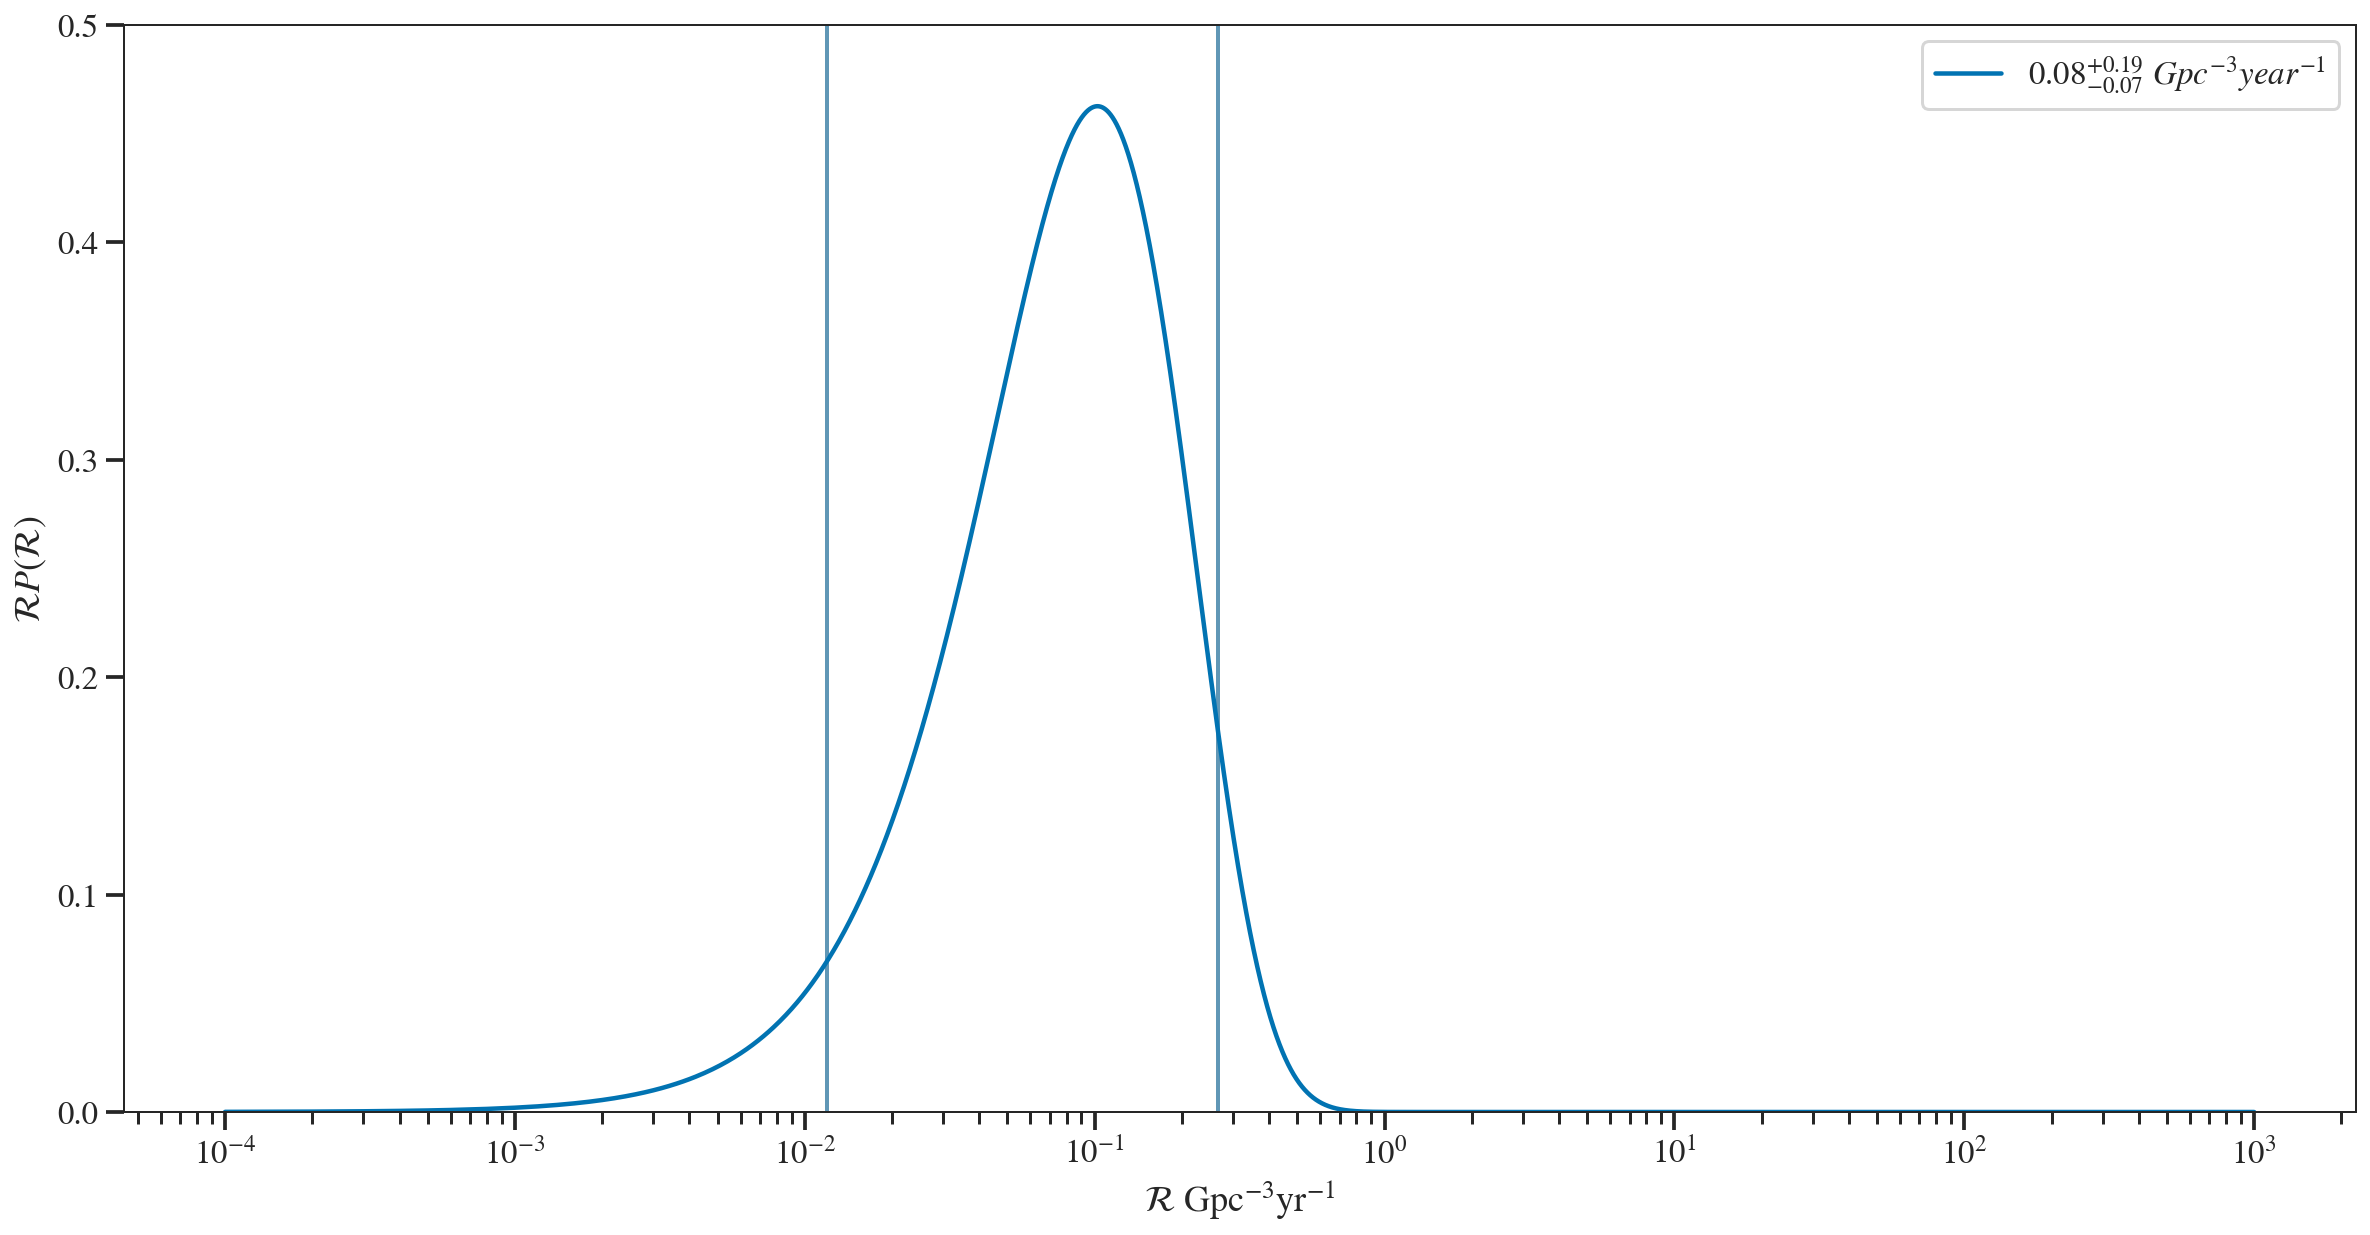

In [8]:
colors = sns.color_palette("colorblind", n_colors=9, desat=.7)
linestyles = ['-',':']
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
lw=2
alpha = 0.7
rs = np.linspace(1e-4,1e3 ,10000000)
CL = .9

# VT, with 1 detection
#VT_190521 = 9.109 #Gpc^3 yr
Nobs = 1

#Get 90% CI
rminus, rmed, rplus = get_bounds_single(rs, VT_190521,Nobs,
                                                  CL, poisson_with_prior, prior = lambda x: x**-0.5)
    
label = make_label(rmed, rminus,rplus,2)
        
ax.axvline(rmed-rminus, color=colors[0], linewidth=lw,alpha=alpha)
ax.axvline(rmed+rplus, color=colors[0], linewidth=lw,alpha=alpha)

#Plot Rate Posterior
ax.semilogx(rs, rs*poisson_with_prior(rs, VT_190521,Nobs,prior = lambda x: x**-0.5), label = label + ' $Gpc^{-3} year^{-1}$')
ax.set_ylabel('$\mathcal{R}P(\mathcal{R})$')
ax.set_xlabel('$\mathcal{R}$ Gpc$^{-3}$yr$^{-1}$')
ax.set_ylim(0,0.5)
ax.legend()

In [9]:
VT_190521

14.67189167943381

In [10]:
N_rec

24119

In [11]:
numpy.max(livetime_of_pipelines)

0.874

In [12]:
fap_threshold

0.00870191722856728